In [1]:
import numpy as np
import os   # 운영체제와 상호작용하기 위한 모듈
from dotenv import load_dotenv

load_dotenv()
base_dir = os.getenv('BASE_DIR')

# GPU 선택 -> '0': 첫 번째
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# GPU 메모리의 동적 할당 허용
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
data = np.concatenate([
    np.load(os.path.join(base_dir, 'seq_angle_data/seq_npy_angle_1721980853.npy')),
    np.load(os.path.join(base_dir, 'seq_angle_data/seq_npy_angle_flip_1721980907.npy')),
    # np.load(os.path.join(base_dir, 'seq_angle_data/seq_npy_angle_shift_1721982182.npy')),
    # np.load(os.path.join(base_dir, 'seq_angle_data/seq_npy_angle_shift_flip_1721982229.npy'))
], axis=0)

print(data.shape)
# (데이터의 개수, 프레임 사이즈, 한 프레임당 데이터 개수)

(18906, 30, 298)


In [3]:
# 시퀀스의 마지막 요소 제외한 모든 값 가져와 할당
# 마지막 요소는 라벨 값
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(data.shape)
print(labels.shape)
print(np.unique(labels))  # 레이블 값 출력

(18906, 30, 298)
(18906,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49.]


In [4]:
from setting import actions
from tensorflow import keras
from keras.utils import to_categorical

# 원-핫 인코딩으로 변환
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape
# y_data 형태 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...]

(18906, 50)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)  # 입력 데이터
y_data = y_data.astype(np.float32)  # 레이블

# train data : validation data : test data = 6 : 2 : 2
x_train_val, x_test, y_train_val, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=2024)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=2024)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

print(x_train.shape[1:3])

(11343, 30, 297) (11343, 50)
(3781, 30, 297) (3781, 50)
(3782, 30, 297) (3782, 50)
(30, 297)


In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(128, activation='relu', input_shape=x_train.shape[1:3], return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='relu'),  # 추가된 LSTM 레이어
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(len(actions), activation='softmax'),
])

# compile(최적화 알고리즘, 레이블 클래스 2개 이상일 때 사용하는 손실 함수, 모델평가지표)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 128)           218112    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 50)                3250      
                                                                 
Total params: 274930 (1.05 MB)
Trainable params: 27493

In [11]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# 모델 훈련
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[
        # save_best_only -> 모델 정확도가 이전보다 향상된 경우에만 모델 저장
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        # 정확도 개선이 없을시 학습률(factor) 0.5배로 감소, n 에포크 동안 개선 없을 경우 학습률 감소
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=20, verbose=1, mode='auto'),
        # early stopping 적용
        # EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ]
)

Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 3.7683 - acc: 0.0528
Epoch 1: val_acc improved from -inf to 0.10764, saving model to models\model.h5
45/45 [==============================] - 11s 181ms/step - loss: 3.7683 - acc: 0.0528 - val_loss: 3.4070 - val_acc: 0.1076 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 3.2946 - acc: 0.1273
Epoch 2: val_acc improved from 0.10764 to 0.19069, saving model to models\model.h5
45/45 [==============================] - 7s 153ms/step - loss: 3.2946 - acc: 0.1273 - val_loss: 2.9816 - val_acc: 0.1907 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 2.8771 - acc: 0.2013
Epoch 3: val_acc improved from 0.19069 to 0.25628, saving model to models\model.h5
45/45 [==============================] - 9s 197ms/step - loss: 2.8771 - acc: 0.2013 - val_loss: 2.5621 - val_acc: 0.2563 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - ETA: 0s - loss: 2.5904 - acc

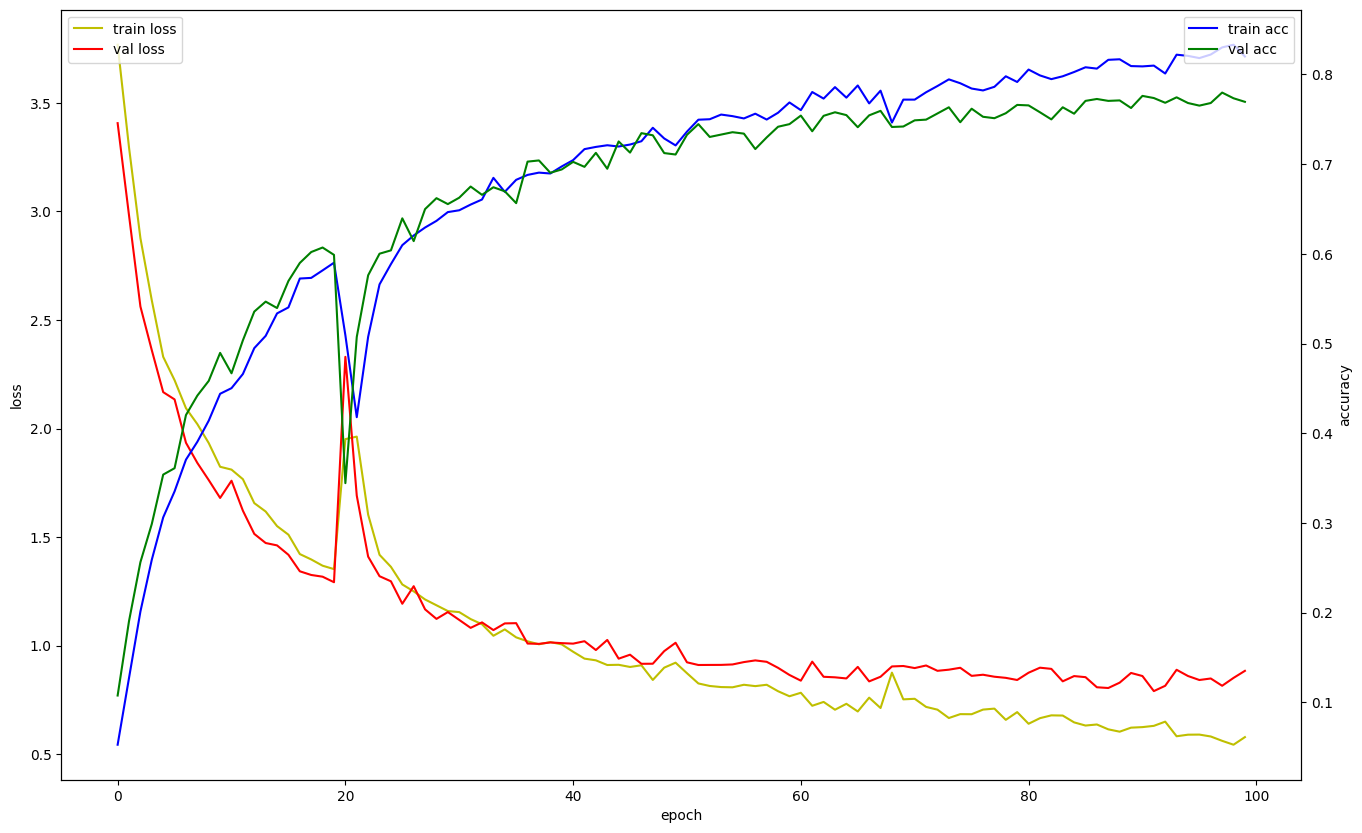

In [12]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [13]:
from keras.models import load_model

model = load_model('models/model.h5')
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"테스트 손실: {test_loss:.3f}")
print(f"테스트 정확도: {test_acc:.3f}")

119/119 [==============================] - 2s 12ms/step - loss: 0.8129 - acc: 0.7753
테스트 손실: 0.813
테스트 정확도: 0.775
